# Creating a Digit Recognizer Model with the Kaggle MNIST Dataset
## A Newbies First Attempt at a High Performance Deep learning with Model Ensembling, Achieved 99.68% accuracy
Reader beware, newbie at work.

Over the past few years I have played with the idea of truly mastering Deep Learning. Last year I actually studied up and managed to earn the Tensorflow Certification for Deep Learning. An achievement I'm still proud of, but must admit was much easier than I was expecting. I walked away thinking that it was more of an very basic introduction than a high ranking goal for truly learning this field. So this year I decided to really do my best to learn everything I can about creating Deep Learning models myself and with the intention of making as good of a model as I can. To that end I decided to start at the very beginning with the MNIST dataset, and to make it extra interesting I decided to use this opportunity to learn another deep learning framework besides Tensorflow, PyTorch. 

In this notebook I go over my initial data analysis, model architecture, training strategy and ensembling approach to build the highest performing model that I can on the Kaggle version of the MNIST dataset. With a focus on maintaining reproducability for the experiments. The final model will be an ensemble model of the top 10 performing models. For this notebook we will train 30 models in total each with 40 epochs. We will use data augmentation to produce new images from our training dataset to help generalize the model to the best of our ability. 

In the end I was able to develop a rough model pipeline that can produce a model that achieved 99.685% accuracy on the hidden dataset in Kaggle, with additional manual testing I found a subset of all trained models that achieve an accuracy of 99.7% through trial and error. 

I will also summarize some of the lessons I've learned and what I will take into account for future projects. 

<b>A NOTE ON REPRODUCABILITY:</b> One of the major take aways I got from this project was the need to be able to reproduce the results of an experiment, so long as nothing has changed it's important to be able to hit run and get the same scores and metrics and previous runs. This is vital for ensuring that a change made to the code actually benefits or hurts the end result, otherwise it's possible that a change you made was actually hurtful overall, but because of a lucky split of the data the metrics turned out positive. That being said, I was not able to fully replicate the results of this notebook on Kaggle. After experimenting with the various offerings on kaggle for gpu acceleration I believe the issue has to do with the GPUs themselves. My own GPU on my local machine is an Nvidia 3090 with cuda 11.6, the offerings on Kaggle are a duel T4 gpu setup with Cuda 11.3, and a P100 gpu again with Cuda 11.3. Each of these gpus running the same notebook produced different end results. Those end results were always the same, so everytime you ran the notebook on the P100 you would get the same result, but that result would differ from runs on the T4 gpus and my 3090. This is really confusing considering that the Cuda version for the Kaggle offerings are the same, so this makes me wonder if perhaps there is some architecture differences in play, but this is pure speculation. All that to say, if you run this notebook on a kaggle kernel the results will vary. I have saved the models from my local training to github if you want to use them. I'm really sorry, I tried my best to figure it out but was unable to, I still would like to share the notebook as at least a record of my attempt. 

## Importing libraries and defining some variables

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchvision import datasets, transforms
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, RandomPerspective, RandomAffine, Lambda, Normalize, ColorJitter, ToPILImage
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import torchvision
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
import time
import json
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import sklearn
import os
import math
from PIL import Image
from collections import Counter
import random
import warnings
warnings.filterwarnings("ignore")

C:\Users\Tyler\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
print("Torch version: ", torch.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("torchvision version: ", torchvision.__version__)
print("sklearn version: ", sklearn.__version__)
print("cuda version: ", torch.version.cuda)

Torch version:  1.13.0+cu116
Numpy version:  1.24.2
Pandas version:  1.4.2
torchvision version:  0.14.0+cu116
sklearn version:  1.0.2
cuda version:  11.6


In [3]:
# this might be needed depending on your cuda version and gpu. Some of the newer version of cuda have non-deterministic actions for certain events which plays havoc on reproducability, 
# this forces cuda to use a deterministic version of actions when available. 
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

Check what type of compute environment we have, if we have a gpu we can utilize. 

In [4]:
print(f'available devices: {torch.cuda.device_count()}')
print(f'current device: { torch.cuda.current_device()}')

available devices: 2
current device: 0


In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device: ", device)

device:  cuda


In [6]:
random_seed = 31262 # define a random seed to ensure reproducability of results
num_models_to_train = 30 # since our end goal will be an ensemble of our top models, we will define how many models we want to train overall here
num_epochs = 40 # likewise how long to train each model

In [7]:
input_folder_path = "../input/" # where's all the data?
checkpoint_location = "./model_checkpoints/" # intermediate folder where we will store our model checkpoints
scores_json_location = "./model_data.json" # also define a location to store a json file with our model data, such as final accuracy score and file location. 

# verify our model checkpoint directory exists.
if not os.path.exists(checkpoint_location):
    os.makedirs(checkpoint_location)

In [8]:
num_models_to_ensemble = 10 # how many of the top models do we want to include in our ensemble model. 

batch_size = 1024 # batch size used for training

## Data Analysis
so first thing's first, let's load in our data and do some light analysis.

In [9]:
# load our training data
train_df = pd.read_csv(input_folder_path+"train.csv")
train_labels = train_df['label'].values
train_features = (train_df.iloc[:,1:].values).astype('float32')

In [10]:
print(train_df.shape)

(42000, 785)


### Visualize  some images

image shape:  (28, 28)
image min/max: (0.0, 255.0)


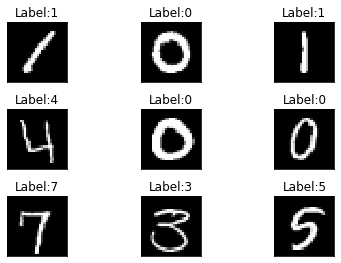

In [11]:
columns = 3
rows = 3
fig = plt.figure()
print("image shape: ", train_features[0].reshape((28, 28)).shape)
print("image min/max: (%s, %s)"%(train_features[0].min(), train_features[0].max()))
for i in range(columns*rows):
    image = train_features[i].reshape((28, 28))
    plt.subplot(columns, rows, i+1)
    plt.tight_layout()
    plt.imshow(image, cmap="gray", interpolation="none")
    plt.title("Label:"+str(train_labels[i]))
    plt.xticks([])
    plt.yticks([])

So each image is 28x28 pixels and single channel, so no color information we need to be concered about. We can also see that the values for the image range from 0 to 255. We will need to normalize these into a 0 to 1 range later. Luckily Pytorch will make this easy for us 

Just looking at the samples here we can already see some variation with samples with the same label, that first '1' is very lopsided and some '0's look like they're drawn more thickly than others, and some are more round or oval. We'll need a pretty robust network to help generalize to these differences. 

### Class Distribution
Let's ensure that we don't have any balance issues with our classes.

Counter({1: 4684, 7: 4401, 3: 4351, 9: 4188, 2: 4177, 6: 4137, 0: 4132, 4: 4072, 8: 4063, 5: 3795})


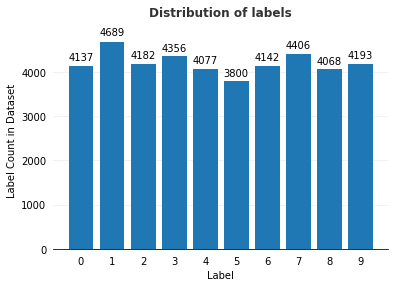

In [12]:
counter = Counter(train_labels)
print(counter)
fig, ax = plt.subplots()
bars = ax.bar(counter.keys(), counter.values(), tick_label=list(counter.keys()))
ax.tick_params(bottom=False, left=False)
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)
ax.set_xlabel("Label")
ax.set_ylabel("Label Count in Dataset")
ax.set_title("Distribution of labels",  pad=15, color="#333333", weight="bold")

for bar in bars:
    ax.text(
      bar.get_x() + bar.get_width() / 2,
      bar.get_height() + bar.get_height()*.03,
      round(bar.get_height()+ 5, 1),
      horizontalalignment='center'
    )

    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
    
plt.show()

So the classes aren't totally even, class '1' has the most samples, and '5' has the fewest. We might want to keep this in mind in case we run into issues training the model later, as it might over predict for 1 and underpredict for 5. For this beginner dataset I don't think this will be much of an issue, but always useful to check and keep in mind. 

## Data Preperation 
The only data cleaning we will need to do is to normalize the image values to a range between 0 and 1, we want the inputs to be small so that it's easier for our network to learn off of them and to prevent the weights from exploding (getting too large of values as to near infinity). Luckily when we convert our data to a tensor using ToTensor from a PIL image the function automatically does that for us. So all we need to do is create a transform to convert to a PIL image then a tensor. Easy. 

The other aspect we will want to prep for is data augmentation. This is where we will take our training data and slightly tweak the image to produce another sample. This can be things like rotating the image slightly, scaling up or down, shifting the image left or right, or adjust the color so it's slightly different. All of these will produce slight variations to our data that our model can use to better generalize to the concept behind a number 3 rather than just trying to memorize the training data itself. We will apply these transforms randomly, so everytime we go to get more data it will always be slightly different. Note: When using actions that require randomness or aren't deterministic be sure to keep reproducability in mind, later in this notebook we set our random seeds, so everytime we rely on randomness we will generate the same set of random numbers, so everytime we run this notebook we get the same results, but without this then our results can vary wildly between each run. 


In [13]:
# create a transform pipeline to convert to an image, apply random rotation, translation, scale and color jitter. Also convert to a tensor to be fed into our model. 
train_transform = transforms.Compose([
    ToPILImage(),
    RandomRotation(degrees=(-15, 15)),
    RandomAffine(degrees=5, translate=(0.15,0.15), scale=(0.75, 1.15)),
    ColorJitter(brightness=0.1, contrast=0.1),
    ToTensor(),
])

We'll also need to create a custom torch dataset class, this will help us control how we fetch and generate samples to train our model on. With this class we can just pass in our images and labels and our transform pipeline and we can write code to format
the images as needed and apply the transform

In [14]:
class CustomTensorDataset(torch.utils.data.Dataset):
    # images df, labels df, transforms
    # uses labels to determine if it needs to return X & y or just X in __getitem__
    def __init__(self, images, labels, transform=None):
        self.X = images
        self.y = labels
        self.transforms = transform
                    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = self.X[i] # gets the row
        # reshape the row into the image size 
        data = np.array(data).astype(np.uint8).reshape(28, 28) 
        
        # perform transforms if there are any
        if self.transforms:
            data = self.transforms(data)
            
        
        # if !test_set return the label as well, otherwise don't
        if self.y is not None: # train/val
            return (data, self.y[i])
        else: # test
            return data

Finally create some helper functions that can take in a set of features, labels, transformer pipeline and generator (to help control the randomness for reproducability) and return a DataLoader. 

Pytorch's dataloaders help batch our data to help with memory constraints or to just help with organization, they're a useful tool in the pytorch utilities!

We also create a helper function that can take in a compelete dataset and split it into a train and test dataset. For each model we will use a different cut of the data for training and testing, so each model will be trained on slightly different data. There is an argument to be made that the same test and train data should be used for each model we train, but so long as our final validation dataset remains static I think it's fine to use a different train/test set for each model we will experiment with. 

In [15]:
def create_dataloader(features, labels, transformer, generator):
    train_images_tensor = torch.tensor(features)
    train_labels_tensor = torch.tensor(labels)
    train_tensor = CustomTensorDataset(train_images_tensor, train_labels_tensor, transform=transformer)    
    train_dataloader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True, generator=generator)
    return train_dataloader
    
        
def create_train_val_dataloaders(features, labels, train_transformer=None, test_transformer=None, test_size=.2):
    train_images, val_images, train_labels, val_labels = train_test_split(features, labels,
                                                                     stratify=labels,
                                                                     test_size=test_size)
   
    if test_transformer == None:
        test_transformer = ToTensor()
    if train_transformer == None:
        train_transformer = ToTensor()
    train_dataloader = create_dataloader(train_images, train_labels, train_transformer, g)
    
    val_dataloader = create_dataloader(val_images, val_labels, test_transformer, g)
    return train_dataloader, val_dataloader

Finally we will create a torch generator which will help us with reproducability, we'll feed it the same seed every time and it will produce the same set of "random" numbers. This way we can validate if a certain approach or modification to our training routine works or if it was just a really lucky training iteration. 

In [16]:
g = torch.Generator()
g.manual_seed(random_seed)

## Defining our model
So full disclosure, this model architecture is probably way bigger than it needs to be, however this was an intentional choice to make it larger. While this does increase the risk of overfitting and take longer to converge, the end goal of this notebook is to create an ensemble model, so we want our smaller models to be more diverse to make up for each others weaknesses, where 1 model fails to predict correctly we want 2-3 other models to make up for that mistake. To that end we want a model architecture that allows for models to learn in different ways, a larger model means there are more parameters and more local minima that it can settle into, meaning the final model has a better opportunity to be different than a previously trained model. With smaller models there is a risk that they all essentially backpropogate to the same configuration. 

So larger model it is, and we'll just be sure to keep an eye not to overfit during training. 

The model itself uses 6 convolutional network layers, with Max Pooling and batch normalization between each layer with a LeakyReLU activation function. We then flatten the inputs and pass them through a 512 node linear layer, again with batch norm and LeakyReLU before passing to our output layer for our 10 classes. We wrap it up by using a log_softmax function to produce probabilities for each class.

We also include a dropout layer for each individual layer configured to 10% probability, to help with generalization. 

In [17]:
class Model(nn.Module):
    def __init__(self, dropout_rate=.1):
        super(Model, self).__init__()          
        self.sequential_layers = nn.Sequential(
            nn.Conv2d(1, 64, 3, bias=False, padding=1), 
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
             nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 64, 3, bias=False), 
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
             nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 64, 3, bias=False, padding=1), 
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(64),
             nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Conv2d(64, 128, 3, bias=False, padding=1), 
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
             nn.LeakyReLU(),
            nn.Dropout(dropout_rate),   
            
            nn.Conv2d(128, 128, 3, bias=False, padding=1), 
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
             nn.LeakyReLU(),
            nn.Dropout(dropout_rate), 
            
            nn.Conv2d(128, 128, 3, bias=False, padding=1), 
            nn.MaxPool2d(kernel_size=(3, 3), stride=1, padding=1),
            nn.BatchNorm2d(128),
             nn.LeakyReLU(),
            nn.Dropout(dropout_rate),                                
            
            nn.Flatten(1, -1),
            
            nn.LazyLinear(512, bias=False),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(),
            nn.Dropout(dropout_rate),
            
            nn.LazyLinear(10, bias=False),
            nn.BatchNorm1d(10)
            
        )
    def get_logits(self, x):
        return self.sequential_layers(x)
    
    def forward(self, x):
        logits = self.get_logits(x)
        return F.log_softmax(logits, dim=1)

## Model Training
So now we have a model architecture defined, time to start training. 

For each model we will use an Adam Optimizer with a learning rate of 0.001 and a weight decay of 1e-5. The weight decay applies a L2 regularization on the model, meaning that it helps prevent overfitting and exploding weights, so it helps control the learning of the model basically. 
We also define a learning rate decay of .98 for each epoch, meaning the learning rate will decrease by .98 every time we start a new training epoch, this lets our model converge to a better score, without it the backpropogation might have the model cycle never reaching a good local minima, this way we get a bit closer to that goal. Our loss function is going to be cross entropy which is a good loss function for this type of problem. 

We will train n models (in this case n=30), and we'll score each model based on how well it does on the entire training dataset (not just its specific validation set), the top 10 models will then be selected to form an ensemble model to make our final predictions. We only use the top 10 because if we include too many models we just add to much noise to the final predictions, around 7-11 models seems to be the ideal sweet spot from my experimentation. 10 is a good even number so that's what we choose. 

### Training Helper Functions
Since we'll be training several nets it'll be helpful to go ahead and define a few functions we can reuse. This is by no means the best pipeline for training, in fact looking at the number of parameters in the train_model function it probably could have benefited from some refactoring and cleanup, maybe even just turn it into a class, but I digress. 

Everything is pretty standard, we will save the best weights from the model after every epoch as based on the accuracy of the test data, and at the end of the training cycle we will reload the best weights and return that model as the final model. There's room for improvement but it does it's job. 

In [18]:
def train_step(model, loss_fn, accuracy_fn, optimizer, train_dataloader, device, eval_loss_fn=None):    
    model.train()
    train_loss = 0
    train_accuracy = 0
    for batch_index, (data, target) in enumerate(train_dataloader):
        data = data.unsqueeze(1)
        data = data.squeeze(1)
        data, target = data.to(device), target.to(device, dtype=torch.int64)
        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        train_accuracy += accuracy_fn(output, target).item()
        if eval_loss_fn==None:
            train_loss += loss.item()
        else:
            train_loss += eval_loss_fn(output, target).item()
        del data
        del target
    train_loss /= len(train_dataloader.dataset)
    train_accuracy /= len(train_dataloader.dataset)
    return train_loss, train_accuracy
        
def test_step(model, loss_fn, accuracy_fn, test_dataloader, device):
    model.eval()
    test_loss = 0
    test_accuracy = 0
    total_pred = np.zeros(0)
    total_target = np.zeros(0)
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device, dtype=torch.int64)
            output = model(data)          
            
            test_loss += loss_fn(output, target).item()
            test_accuracy += accuracy_fn(output,target).item()
            del data
            del target

    test_loss /= len(test_dataloader.dataset)
    test_accuracy /= len(test_dataloader.dataset)
    return test_loss, test_accuracy
    

def train_model(model, loss_fn, accuracy_fn, optimizer, train_dataloader, test_dataloader, num_epochs, device, verbose=True, eval_loss_fn=None, print_epoch_summary_interval=10, print_first_epoch=True,lr_scheduler=None, lr_step=2):
    training_loss_histogram = []
    training_accuracy_histogram = []
    testing_loss_histogram = []
    testing_accuracy_histogram = []
    best_state = model.state_dict()
    best_accuracy = 0
    model_checkpoint_path =checkpoint_location+"checkpoint.pt"
    if eval_loss_fn == None:
        eval_loss_fn = loss_fn
    for epoch in range(num_epochs):
        if (((1+epoch)%print_epoch_summary_interval==0) or (epoch==0 and print_first_epoch)) and verbose: 
            print("starting epoch ", (epoch+1))
        train_loss, train_accuracy = train_step(model, loss_fn, accuracy_fn, optimizer, train_dataloader, device, eval_loss_fn=eval_loss_fn)
        
        
        if (((1+epoch)%print_epoch_summary_interval==0) or (epoch==0 and print_first_epoch)) and verbose: 
            print("evaluating for epoch")
        
        
        test_loss, test_accuracy = test_step(model, eval_loss_fn, accuracy_fn, test_dataloader, device)
        
        if (((1+epoch)%print_epoch_summary_interval==0) or (epoch==0 and print_first_epoch)) and verbose: 
            print("training loss: %s, training accuracy: %s | testing loss: %s, testing accuracy: %s"%(train_loss, train_accuracy, test_loss, test_accuracy))
            print("-"*10)
        
        if test_accuracy >= best_accuracy:
            best_accuracy = test_accuracy            
            torch.save(model.state_dict(), model_checkpoint_path)
        
        training_loss_histogram.append(train_loss)
        training_accuracy_histogram.append(train_accuracy)
        testing_loss_histogram.append(test_loss)
        testing_accuracy_histogram.append(test_accuracy)
        if lr_scheduler != None and (epoch+1)%lr_step==0:
            lr_scheduler.step()    
    model.load_state_dict(torch.load(model_checkpoint_path))
    os.remove(model_checkpoint_path)
    test_loss, test_accuracy = test_step(model, eval_loss_fn, accuracy_fn, test_dataloader, device)
        
    if (((1+epoch)%print_epoch_summary_interval==0) or (epoch==0 and print_first_epoch)) and verbose: 
        print("training loss: %s, training accuracy: %s | testing loss: %s, testing accuracy: %s"%(train_loss, train_accuracy, test_loss, test_accuracy))
        print("-"*10)
    
    testing_loss_histogram.append(test_loss)
    testing_accuracy_histogram.append(test_accuracy)
    return training_loss_histogram, training_accuracy_histogram, testing_loss_histogram, testing_accuracy_histogram

In [19]:
# also define an accuracy function just to make things a bit easier for us. 
def accuracy(output, target):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(target.view_as(pred)).sum()
    return correct
    

## Reproducability
It's at this point we need to take some steps to ensure reproducability. We want to get the same results every time we run this notebook, that way we can validate if any changes we make actually result in a change the the results, or if we just got lucky with a particularly good training session. To that end we need to make sure and seed every possible random number source that our model can draw from. 

In [20]:
torch.manual_seed(random_seed)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

random.seed(random_seed)

np.random.seed(random_seed)

## Train our models
Now for what we've been waiting for, time to train our models. Pretty straight forward loop, for each model we define a new train/test split of the data and pass everything to our training function above, after training we save the model for future use, we'll also keep track of each model's final accuracy based on it's validation set and save a json file with that information. Just in case our run is interupted we can pick up where we left off, or end it early if we so choose, although this will affect the final accuracy. 

our loop will also print out some stats to help us guage how well each model did after training as well as how long it took.

In [21]:
model_scores = {}
training_start_time = time.time()
for i in range(num_models_to_train):
    train_dataloader, val_dataloader = create_train_val_dataloaders(train_features, train_labels, train_transformer=train_transform, test_size=.1)
    print("training model ", i)
    model_id = "Model_"+str(i)
    model_path =checkpoint_location+model_id+".pt"
    model = Model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)
    loss_fn = F.cross_entropy
    
    train_start = time.time()
    training_loss_hist, training_accuracy_histogram, testing_loss_hist, testing_accuracy_histogram = train_model(model, loss_fn, accuracy, optimizer, train_dataloader, val_dataloader, num_epochs, device, verbose=False, lr_scheduler=lr_scheduler, print_epoch_summary_interval=5)
    test_accuracy = testing_accuracy_histogram[-2]
    max_accuracy = max(testing_accuracy_histogram) # this max accuracy is the final accuracy of our model, since the training function loads back in the best performing model before returning. 
    training_time = time.time() - train_start
    elapsed_time = time.time() - training_start_time
    print("model id %s training iteration %s accuracy: %s | max accuracy: %s | training time: %s elapsed time: %s"%(model_id, i, test_accuracy, max_accuracy, training_time, elapsed_time))
    
   
    model_scores[model_id] =  {
        "file_path":model_path,
        "score": max_accuracy
    }
    cpu_model = model.cpu()
    torch.save(model.state_dict(), model_path)
    del model
    with open(scores_json_location, "w") as outfile:
        json.dump(model_scores, outfile)
    print("-"*10)

training model  0
model id Model_0 training iteration 0 accuracy: 0.9957142857142857 | max accuracy: 0.996904761904762 | training time: 1105.7238903045654 elapsed time: 1106.6318905353546
----------
training model  1
model id Model_1 training iteration 1 accuracy: 0.9952380952380953 | max accuracy: 0.9954761904761905 | training time: 1080.475299358368 elapsed time: 2188.462182044983
----------
training model  2
model id Model_2 training iteration 2 accuracy: 0.9942857142857143 | max accuracy: 0.9966666666666667 | training time: 1042.3256151676178 elapsed time: 3232.1672914028168
----------
training model  3
model id Model_3 training iteration 3 accuracy: 0.9942857142857143 | max accuracy: 0.9957142857142857 | training time: 1041.7905015945435 elapsed time: 4275.349795103073
----------
training model  4
model id Model_4 training iteration 4 accuracy: 0.995 | max accuracy: 0.9973809523809524 | training time: 1036.567997455597 elapsed time: 5313.277292251587
----------
training model  5
m

# Checkpoint
At this point our models and our model json have been saved to disk, so if something were to happen, say you have to stop the notebook and restart, you could pick up from here rather than having to rerun the entire training segment again. 

In [22]:
# load back in our model scores data
model_scores_values = list(model_scores.values())
model_scores_values # verify the contents....just in case

[{'file_path': './model_checkpoints/Model_0.pt', 'score': 0.996904761904762},
 {'file_path': './model_checkpoints/Model_1.pt', 'score': 0.9954761904761905},
 {'file_path': './model_checkpoints/Model_2.pt', 'score': 0.9966666666666667},
 {'file_path': './model_checkpoints/Model_3.pt', 'score': 0.9957142857142857},
 {'file_path': './model_checkpoints/Model_4.pt', 'score': 0.9973809523809524},
 {'file_path': './model_checkpoints/Model_5.pt', 'score': 0.996904761904762},
 {'file_path': './model_checkpoints/Model_6.pt', 'score': 0.9966666666666667},
 {'file_path': './model_checkpoints/Model_7.pt', 'score': 0.9959523809523809},
 {'file_path': './model_checkpoints/Model_8.pt', 'score': 0.9945238095238095},
 {'file_path': './model_checkpoints/Model_9.pt', 'score': 0.996904761904762},
 {'file_path': './model_checkpoints/Model_10.pt', 'score': 0.9961904761904762},
 {'file_path': './model_checkpoints/Model_11.pt', 'score': 0.996904761904762},
 {'file_path': './model_checkpoints/Model_12.pt', 'sco

now we load back in our models for another round of evaluation, now we want to score each model based on how well it does against the entire training data and sort them based on those scores



In [23]:
models = []
for model_details in model_scores_values:
    file_path = model_details['file_path']
    model = Model()
    model.load_state_dict(torch.load(file_path))
    models.append(model)

## Final Model Selection
now we need to find the top 10 models we want to ensemble. We'll do this by scoring each model on the entire dataset and selecting the best overall performers.

In [24]:
# very similar to the loop we had before, this time we just pass in a single dataloader to our test_step function to get an overall accuracy. 
train_dataloader = create_dataloader(train_features, train_labels, ToTensor(), g)
best_accuracy = 0 
best_n = 1
scores = []
for i, model in enumerate(models):
    device_model = model.to(device)
    loss_eval_fn = lambda output, target: F.nll_loss(output,target, reduction='sum')

    test_loss, test_accuracy = test_step(device_model, loss_eval_fn, accuracy, train_dataloader, device)
    del device_model
    print(i, test_accuracy)
    scores.append((test_accuracy, model, i))
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_n = i


0 0.9980952380952381
1 0.9972380952380953
2 0.9980238095238095
3 0.9978809523809524
4 0.9980714285714286
5 0.9976666666666667
6 0.9980238095238095
7 0.9981428571428571
8 0.9980476190476191
9 0.9980476190476191
10 0.9982142857142857
11 0.9978809523809524
12 0.9979523809523809
13 0.9982380952380953
14 0.996904761904762
15 0.9978333333333333
16 0.9983333333333333
17 0.9965714285714286
18 0.997452380952381
19 0.997547619047619
20 0.9976428571428572
21 0.9976190476190476
22 0.9977857142857143
23 0.9970476190476191
24 0.9982142857142857
25 0.998
26 0.9979047619047619
27 0.9979761904761905
28 0.9982619047619048
29 0.9975714285714286


In [25]:
# now that we have the model scores on the entire training dataset, sort the models based on performance
scores.sort(key=lambda x: x[0], reverse=True)
scored_models = [x[1] for x in scores]

In [34]:
# and select the top 10 models
selected_models = scored_models[:num_models_to_ensemble]

## Ensembling
Now to take those selected models and ensemble them together to make our final predictions. The actual process is pretty straightforward, pass the data through each model and sum their predictions together and softmax the results to get a final prediction. To make it a bit easier we'll go ahead and use a class to help load and unload each model from the gpu (if present).

In [27]:
class EnsembleModel():
    def __init__(self, sub_models):
        self.models = sub_models 
        self.device = "cpu"
        
    def forward(self, x):
        outputs = []
        for model in self.models:
            device_model = model.to(self.device)
            device_model.eval()
            output = device_model.get_logits(x).detach()
            outputs.append(output)
            del device_model
        output = sum(outputs)
        output = F.log_softmax(output, dim=1)
        return output
    def to(self, device):
        self.device = device
        return self
    def eval(self):
        for model in self.models:
            model.eval()
        
            
    def __call__(self, x):
        return self.forward(x)

In [28]:
# load our test data for the kaggle hold out
holdout_data_df = pd.read_csv(input_folder_path+"test.csv")
holdout_images = (holdout_data_df.iloc[:,:].values).astype('float32')

In [29]:
print(holdout_data_df.shape)

(28000, 784)


In [30]:
holdout_tensor = torch.tensor(holdout_images)
holdout_dataset = CustomTensorDataset(holdout_tensor, None, transform=ToTensor())
holdout_dataloader = DataLoader(holdout_dataset, batch_size=batch_size, generator=g)

ensemble_model = EnsembleModel(selected_models)
ensemble_model.to(device)
loss_fn = F.cross_entropy

predictions = [] 
for features in holdout_dataloader:
    features = features.to(device)
    new_predictions = ensemble_model(features)
    new_predictions = new_predictions.cpu().detach().numpy()
    results = np.argmax(new_predictions, axis = 1)
    predictions.extend(list(results))
    del features
    del new_predictions
df = pd.DataFrame(predictions, columns=['Label'])
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), df],axis = 1)
submission.to_csv("MNIST-ENSEMBLE-SUBMISSION.csv", index=False)

## Final Results and Data Musings, a final score of 99.68% accuracy!
The final submission should earn a score of 99.68%, a respectable score but could be much higher. A major issues with getting a higher score is the data for the Kaggle MNIST dataset compared to toehr MNIST sources. The MNIST dataset has 70k labeled images, the default split is 60k for training and a 10k holdout dataset for validation. This is how sources like PyTorch and Tensorflow seperate the data, kaggle on the other hand has only 42k images for training and 28k for the holdout/validation. If you properly split the data into a train/test set from the training images to prevent overfitting then that means that for kaggle you train on even less. In this notebook we did a 90/10 split for training/test so we trained on 37.8k images, whereas with pytorch we would have trained with 54k. This is a signifigant gap between the sample sizes. That means for the same number of epochs a model trained on the Pytorch split would have seen almost double the amount of images as the kaggle split, that means there was a higher variation of images seen which means the model had a better chance toe generalize and learn the patterns as opposed to the kaggle version. 

Simply put, with a similar model architecture and data augmentation strategy I was able to repeatedly reach a 99.7% accuracy (sometimes as high as 99.75% on a good training run) using the PyTorch split of the data within only 20 training epochs per model, where I struggled to achieve anything higher than 99.5% with the kaggle split with the same number of epochs. 

A more aggressive Data Augmentation strategy helps to bridge this gap, as well as training for more epochs. But overall I was getting diminishing returns with this approach. Even reference notebooks I found on Kaggle struggled to achieve their advertised accuracy, and instead their results seemed more of an occurance of a good training run rather than deliberate strategy (at least it appeared that way). There is no denying that luck plays a part in the final result of the model, how the weights are initialized and how the data is augmented through the random transforms, but I am not unconvinced that there might be a better strategy or approach to effectively reach the 99.75% accuracy I was aiming for originally. 

## Lessons Learned
- Luck plays more of a role in Deep Learning that I originally thought. I always knew that it played a factor but this excersize really highlighted the variance that a model can have.
- Because luck plays such a factor, experiment reproducability is a neccissity for any future projects. I need to be able to determine if an adjustment to the architecture or training strategy resulted in a chance in accuracy or if it was just the luck of the draw.
- Just because the top n models perform well doesn't mean they will produce the best ensemble model from the pool of available models (More on this later in the notebook)
- I am extremely long winded and this notebook is way too long 

## Possible Improvements
- I think that perhaps a more deliberate selection of models based on their performance would be beneficial for ensembling. For example if the top model struggles with a particular class pairing it with a model that performs well in that class but not detrmintally bad for the rest of the classes available would be more beneficial than pairing it with a random model. This way the models work off each other to cover their weaknesses. In this notebook I blindly picked the top 10 models with no other analysis done on their compatability. 
- Perhaps a more deliberate training on the models for a specific class would also help. So rather than training n general models that try to predict every class well, train models to classify a specific class extremely well and does moderatly well on others. A sort of T shaped approach where it does reasonably well on all classes but outperforms on a specific class.
- The ensemble method used here is also pretty basic, simply summing the outputs from the individual models, a more advanced models that take the original image as input and the ensemble models predictions as input into a neural network of it's own might produce better results. The new model might be able to pick out instances of when to listen to a particular model over listening to the others based on patterns that exist in the data. 
- Data Augmentation, I still think the data augmentation I used here could be more robust/aggressive, generating more varied samples to help extend the limited dataset might have helped enhance the final score. 
- Better parallelization, pytorch dataloaders can benefit from having multiple workers to process data and prepare the next batch, however I had issues when trying to enable this on my system and the workers would crash. Need to investigate this to gain performance boost. 
- Writting more concise notebooks on project results!

## Extra: Going beyond the 99.68% with the models from this notebook
As an experiment I decided to randomly select models from the pool of models produced by this notebook, overall I tried countless combinations of the models in this notebook to try and find a combination to beat the above score with the top 10 scoring models. What I found is that it is possible to achieve 99.7% accuracy! It is possible that a higher score is possible with a different combination but this is the highest I found.

With the models arranged in the order they were trained, it's possible to achieve a higher score with the model indicies [10, 8, 3, 24, 4, 5]. These were not selected by any deliberate process or analysis, so I excluded the code I used to find them (was literally just picking them at random), however I did want to show that it was possible to achieve a higher score with the models trained on this notebook with ensembling. The cells below will make an alternate submission csv using these models. 

In [33]:
ideal_model_indicies = [10, 8, 3, 24, 4, 5]
selected_models = [models[i] for i in ideal_model_indicies]

ensemble_model = EnsembleModel(selected_models)
ensemble_model.to(device)
loss_fn = F.cross_entropy

predictions = [] 
for features in holdout_dataloader:
    features = features.to(device)
    new_predictions = ensemble_model(features)
    new_predictions = new_predictions.cpu().detach().numpy()
    results = np.argmax(new_predictions, axis = 1)
    predictions.extend(list(results))
    del features
    del new_predictions
df = pd.DataFrame(predictions, columns=['Label'])
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"), df],axis = 1)
submission.to_csv("MNIST-ENSEMBLE-SUBMISSION-99.7.csv", index=False)

## References and Special Thanks
Before I forget I wanted to point out a few notebooks that I ended up referencing quite a bit for this project. 

* [How to score 97%, 98%, 99%, and 100% by Chris Deotte](https://www.kaggle.com/c/digit-recognizer/discussion/61480) - a really good breakdown of how to achieve different levels of results for the dataset and links to several notebooks for reference. 
* [25 Million Images! [0.99757] MNIST by Chris Deotte](https://www.kaggle.com/code/cdeotte/25-million-images-0-99757-mnist/notebook) - a really good example of ensembling in tensorflow for this dataset. I had some issues replicating some of his results, the highest run I achieved for this ntoebook was 99.67, but still an awesome reference.
* [MNIST Perfect 100% using kNN by Chris Deotte](https://www.kaggle.com/code/cdeotte/mnist-perfect-100-using-knn/notebook) - This was an interesting read, it does "cheat" to achieve the 100% accuracy, but still a useful resource. 
